The notebook provides an example of how to zoom into the best optwrf simulation over a specific region (New York State in this example) to determine why some parameterizations performed better there.

Updated by Jeffrey Sward on November 11, 2020 

In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, geo_bounds)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf
from optwrf import helper_functions as hf
from optwrf import postwrf, plots, util

No module named 'pyresample'


In [2]:
# # Define the path to where you WRF data file is stored 
# # (note: don't forget to add the "/" at the end of the directory)
# wrfout_dir = '/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/Wind Resource Analysis/wrfout/19mp4lw4sw7lsm8pbl99cu/'
# wrfout_file = 'wrfout_d01_2011-07-17'
# wrfout_file_processed = 'processed_' + wrfout_file

# # Process the WRF data
# process_data = False
# if process_data:
#     met_data = postwrf.process_wrfout_manual(wrfout_dir, wrfout_file, save_file=False)
# else:
#     met_data = xr.open_dataset(wrfout_dir+wrfout_file_processed)
# met_data

In [3]:
# Verbose setting
verbose = True

# Define the datestr, paramstr, and wrfout file names
datestr = '2011-12-13'
paramstr = '19mp4lw4sw7lsm8pbl99cu'
# paramstr = '8mp4lw4sw2lsm2pbl6cu'
wrffile_name = f'wrfout_processed_d01_{datestr}_{paramstr}.nc'
wrffile_name_orig = f'wrfout_d01_{datestr}_{paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Specify the path to the processed wrfout file
wrfdir = os.path.join(optwrf_abspath, 'data/optwrf_sim/')
wrffile = os.path.join(wrfdir, wrffile_name)
wrfdata = xr.open_dataset(wrffile)
if verbose:
    print(f'Processeed WRF DATA:\n{wrfdata}\n')
    
# Open the processed ERA5 data
eradir = os.path.join(optwrf_abspath, 'data/ERA5/')
erafile = os.path.join(eradir, 'ERA5_EastUS_WPD-GHI_2011-12.nc')
eradata = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{eradata}')

Processeed WRF DATA:
<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 ...
    wind_speed10    (Time, south

In [4]:
# Get the map projection information for plotting
wrf_cartopy_proj = plots.get_wrf_proj(wrfdata, 'ghi')

The next step is to define a subset of the domain that you would like to create plots for. There are a copule of functions to do this in optwrf, but we will use the Kdtree class that's based upon the scipy cKDTree package.

In [5]:
# Idnetify the points for your bounding box
lltoxy = util.Kdtree_ll_to_xy(wrfdata,'lat','lon')
lower_lat_idx,lower_lon_idx = lltoxy.query(41.706178, -81.865276)  # Near Cleavland
upper_lat_idx,upper_lon_idx = lltoxy.query(44.700326, -69.296917)  # Sorta near Bangor

print(f'Latitude Indicies: {lower_lat_idx}:{upper_lat_idx}')
print(f'Longitude Indicies: {lower_lon_idx}:{upper_lon_idx}')

Latitude Indicies: 108:154
Longitude Indicies: 91:167


In [6]:
# Slice the data (in this case DNI) to this bounding box, and do a quick visualization
wrfdata_subset = wrfdata.isel(south_north=slice(lower_lat_idx, upper_lat_idx), 
                               west_east=slice(lower_lon_idx, upper_lon_idx))

# Decide which time you would like to plot
time_string_f = wrfdata_subset.Time[14].dt.strftime('%b %d, %Y %H:%M')
# wrfdata_subset.ghi.sel(Time=time_string_f).plot()

Now we can just use the same plotting functions that we used for the full domain!

In [7]:
# # Create a plot of a single quantity for either wrf or era5 data.
# figpath = f'/Users/jsward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/NYGHIerr_{datestr}_{paramstr}'
# plots.wrf_era5_plot('ghi_error', wrfdata_subset, eradata, paramstr, src='wrf', hourly=False, save_fig=True,
#                     fig_path=figpath, wrf_dir=wrfdir, era_dir=eradir, short_title_str='OptWRF GHI Error\n(kWh m-2 day-1)', max=2.5)


In [8]:
# # Create a plot of a single quantity for either wrf or era5 data.
# figpath = f'/Users/jsward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/NYWPDerr_{datestr}_{paramstr}'
# plots.wrf_era5_plot('wpd_error', wrfdata_subset, eradata, paramstr, src='wrf', hourly=False, save_fig=True,
#                     fig_path=figpath, wrf_dir=wrfdir, era_dir=eradir, short_title_str='OptWRF WPD Error\n(kWh m-2 day-1)', max=5000)


In [9]:
# # Create a plot that compares either ghi or wpd between wrf and era5.
# plots.compare_wrf_era5_plot('ghi', wrfdata_subset, eradata, hourly=True, save_fig=False)

The file name is: bilinear_191x191_97x129.nc and reuse_weights is: False


/opt/anaconda3/envs/oshwind/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/opt/anaconda3/envs/oshwind/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


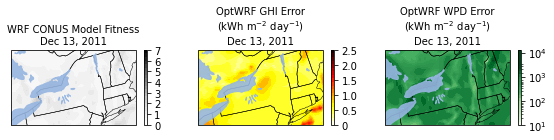

In [10]:
# Create a plot that shows the fitness, ghi error, and wpd error for the wrf model. 
figpath = f'/Users/jsward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/NY_GHI_WPD_Err_Fitness_{datestr}_{paramstr}'
plots.wrf_errorandfitness_plot(wrfdata_subset, paramstr, save_fig=True, wrf_dir=wrfdir, era_dir=eradir,
                             fig_path=figpath, verbose=False, fitness_short_title='WRF CONUS Model Fitness',
                             ghi_error_short_title='OptWRF GHI Error\n(kWh m$^{-2}$ day$^{-1}$)',
                             wpd_error_short_title='OptWRF WPD Error\n(kWh m$^{-2}$ day$^{-1}$)')